In [164]:
#################################################
#created the 02/052018 14:27 by Alexis Blanchet#
#################################################
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import scipy.stats
import matplotlib
import plotly.offline as offline
import plotly.graph_objs as go
from sklearn.cluster import SpectralClustering
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy import stats
from sklearn.metrics import log_loss

In [75]:
df = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180430_0_192_0_cleandata-processed.csv')

In [116]:
y = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/y_true.csv').drop(['Unnamed: 0'],axis = 1)
y.head()

,CP
0,0
1,0
2,0
3,0
4,0


In [77]:
y_pred = df['label']
df = df.drop(['label'],axis=1)

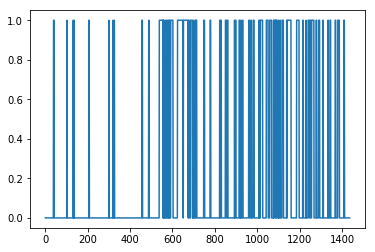

In [78]:
plt.plot(abs(y_pred))

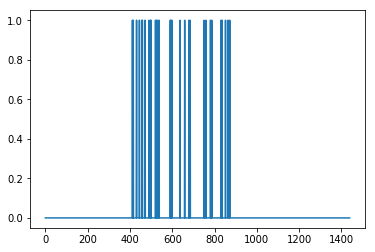

In [79]:
plt.plot(y.values)

In [80]:
X = df[405:875]
Y_pred = y_pred[405:875]
Y = y[405:875]

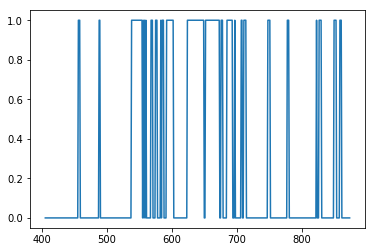

In [83]:
plt.plot(abs(Y_pred))

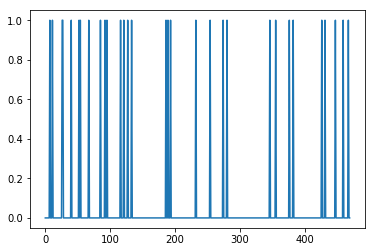

In [84]:
plt.plot(Y.values)

In [159]:
X_train = X.values
y_train = Y['CP'].values

In [160]:
#Some functions and losses for the algorithms

def logloss_lgbm(preds, dtrain):
    labels = dtrain.get_label()
    score = 1-log_loss(labels, preds)
    return 'logloss', score,True

def logloss_xgb(preds, dtrain):
    labels = dtrain.get_label()
    score = log_loss(labels, preds)
    return 'logloss', score


In [161]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
######################################################
### XGB modeling
params = {'eta': 0.02,
          'max_depth': 20, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':1,
          'alpha':2,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
params2 = {'eta': 0.02,
          'max_depth': 15, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':1,
          'alpha':1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'seed': 99,
          'silent': False}
######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y[:X.shape[0]], test_size=0.2, random_state=99)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 5000,  watchlist, maximize = False,verbose_eval=100, early_stopping_rounds=300)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        res = [(r1+r2)*0.5 for r1,r2 in zip(res1,res2)]
        return np.array([ [1-c,c] for c in res])
clf = Classifier()
clf.fit(X.values,Y['CP'])

[0]	train-logloss:0.678863	valid-logloss:0.677629
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 300 rounds.
[100]	train-logloss:0.231962	valid-logloss:0.204577
[200]	train-logloss:0.165642	valid-logloss:0.157823
[300]	train-logloss:0.135971	valid-logloss:0.149432
[400]	train-logloss:0.117976	valid-logloss:0.148181
[500]	train-logloss:0.106377	valid-logloss:0.148377
[600]	train-logloss:0.098952	valid-logloss:0.14821
Stopping. Best iteration:
[346]	train-logloss:0.126834	valid-logloss:0.147337

[0]	train-logloss:0.678715	valid-logloss:0.677481
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 300 rounds.
[100]	train-logloss:0.2122	valid-logloss:0.201879
[200]	train-logloss:0.133834	valid-logloss:0.156077
[300]	train-logloss:0.100513	valid-logloss:0.146801
[400]	train-logloss:0.082002	valid-logloss:0.146837


In [190]:
######################################################
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
######################################################


### LGB modeling
params = {'learning_rate': 0.0015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 6,
          'num_leaves': 10,        
          'min_data_in_leaf': 1, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}

params1 = {'learning_rate': 0.0015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 0.0,
          'reg_lambda': 0,
          'max_depth' : 7,
          'num_leaves': 10,        
          'min_data_in_leaf': 1, 
          'boosting': 'goss',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}
MAX_TREES = 5000

class Classifier1(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        watchlist = [(lgb.Dataset(x1, label=y1), 'train'), (lgb.Dataset(x2, label=y2), 'valid')]
        self.clf2 = lgb.train(params, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
        self.clf1 = lgb.train(params1, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=100, feval=logloss_lgbm, early_stopping_rounds=300)
    def predict(self, X):
        return self.clf1.predict(X)

    def predict_proba(self, X):
        res1 = self.clf1.predict(X, num_iteration = self.clf1.best_iteration)
        res2 = self.clf2.predict(X,num_iteration = self.clf2.best_iteration)
        return [[1-0.5*(a+b),0.5*(a+b)] for a,b in zip(res1,res2)]
        
    
classifier1 = Classifier1()
classifier1.fit(X_train,y_train)

Training until validation scores don't improve for 300 rounds.
[100]	valid_0's binary_logloss: 0.589481	valid_0's logloss: 0.410519
[200]	valid_0's binary_logloss: 0.508935	valid_0's logloss: 0.491065
[300]	valid_0's binary_logloss: 0.445528	valid_0's logloss: 0.554472
[400]	valid_0's binary_logloss: 0.393397	valid_0's logloss: 0.606603
[500]	valid_0's binary_logloss: 0.351367	valid_0's logloss: 0.648633
[600]	valid_0's binary_logloss: 0.320475	valid_0's logloss: 0.679525
[700]	valid_0's binary_logloss: 0.296953	valid_0's logloss: 0.703047
[800]	valid_0's binary_logloss: 0.277993	valid_0's logloss: 0.722007
[900]	valid_0's binary_logloss: 0.262229	valid_0's logloss: 0.737771
[1000]	valid_0's binary_logloss: 0.248922	valid_0's logloss: 0.751078
[1100]	valid_0's binary_logloss: 0.235837	valid_0's logloss: 0.764163
[1200]	valid_0's binary_logloss: 0.225581	valid_0's logloss: 0.774419
[1300]	valid_0's binary_logloss: 0.216909	valid_0's logloss: 0.783091
[1400]	valid_0's binary_logloss: 0.2

In [186]:
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

class Classifier3(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=99)
        self.clf1 = CatBoostClassifier(iterations=2000,learning_rate=0.01, depth=7,metric_period = 50, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf1.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
        self.clf2 = CatBoostClassifier(iterations=2000,learning_rate=0.01, depth=8,metric_period = 50, loss_function='Logloss', eval_metric='Logloss', random_seed=99, od_type='Iter', od_wait=100)
        self.clf2.fit(x1,y1,verbose=True,eval_set=(x2,y2),use_best_model=True)
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return [[0,(v[1]+l[1])*0.5] for v,l in zip(self.clf2.predict_proba(X),self.clf1.predict_proba(X))]

classifier3 = Classifier3()
classifier3.fit(X_train,y_train)

0:	learn: 0.6820929	test: 0.6815604	best: 0.6815604 (0)	total: 8.6ms	remaining: 17.2s
50:	learn: 0.3603961	test: 0.3324302	best: 0.3324302 (50)	total: 412ms	remaining: 15.7s
100:	learn: 0.2613610	test: 0.2226162	best: 0.2226162 (100)	total: 800ms	remaining: 15s
150:	learn: 0.2223863	test: 0.1805846	best: 0.1805846 (150)	total: 1.17s	remaining: 14.3s
200:	learn: 0.1985948	test: 0.1619279	best: 0.1619279 (200)	total: 1.56s	remaining: 13.9s
250:	learn: 0.1808537	test: 0.1545534	best: 0.1545534 (250)	total: 1.99s	remaining: 13.9s
300:	learn: 0.1651144	test: 0.1504665	best: 0.1502182 (292)	total: 2.38s	remaining: 13.4s
350:	learn: 0.1499073	test: 0.1490018	best: 0.1488980 (347)	total: 2.77s	remaining: 13s
400:	learn: 0.1357161	test: 0.1473358	best: 0.1469139 (391)	total: 3.2s	remaining: 12.8s
450:	learn: 0.1234769	test: 0.1455711	best: 0.1454230 (448)	total: 3.61s	remaining: 12.4s
500:	learn: 0.1125124	test: 0.1444530	best: 0.1444005 (492)	total: 4.02s	remaining: 12s
550:	learn: 0.1009770	t

In [176]:
df2 = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20171215_0_192_0_cleandata-processed.csv')
y2 = pd.read_csv('/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20171215_0_192_0_cleandata-y.csv')

In [135]:
df2 = df2.drop(['label'],axis=1)
df2.head()

,t-3,t-2,t-1,t,minutes,diff t t-1,diff t t-2,diff t t-3,diff t-1 t-2,diff t-1 t-3,...,diff pente 1-3,diff pentes,diff pente 2-3,GP,covariance,pics,KDFR,probability,distribution,skewness
0,3861826.0,3919113.0,3930969.0,3908951,3,-22018.0,-10162.0,47125.0,11856.0,69143.0,...,3.601826,-2.063357,-3.831899,0.999968,6.882465e+08,1,1.500000,1.941902e-13,0.5,5.644233e-32
1,3919113.0,3930969.0,3908951.0,3849858,4,-59093.0,-81111.0,-69255.0,-22018.0,-10162.0,...,1.200633,-0.573232,1.538469,0.999764,9.747410e+08,0,0.021532,1.941902e-13,0.5,1.162822e-31
2,3930969.0,3908951.0,3849858.0,3861348,5,11490.0,-47603.0,-69621.0,-59093.0,-81111.0,...,2.916275,3.226719,0.627401,0.999991,1.112557e+09,-1,0.399655,1.941902e-13,0.5,8.752554e-32
3,3908951.0,3849858.0,3861348.0,3979121,6,117773.0,129263.0,70170.0,11490.0,-47603.0,...,1.501753,-0.599314,6.142994,0.999124,2.587080e+09,0,0.156679,1.941902e-13,0.5,6.733439e-31
4,3849858.0,3861348.0,3979121.0,3979017,7,-104.0,117669.0,129159.0,117773.0,129263.0,...,111.480769,50.000000,0.902439,1.000000,3.827467e+09,1,0.191332,1.941902e-13,0.5,8.365564e-31


In [136]:
X_test = df2[405:875].values

In [191]:
def sum_list(a,b):
    c = [x+y for x,y in zip(a,b)]
    return c
res = classifier3.predict_proba(X_test)

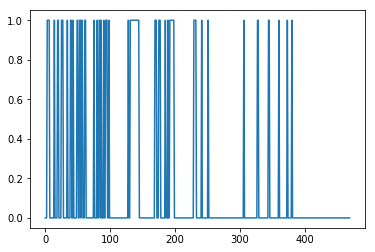

In [200]:
cl = [ 1 if l[1]>0.05 else 0 for l in res]
plt.plot(cl)

In [177]:
y2 = y2[405:875]

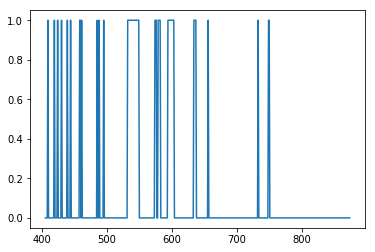

In [195]:
plt.plot(abs(y2))

In [184]:
import pickle
classifier3.clf1.save_model("model1")
classifier3.clf2.save_model("model2")
pickle.dump(classifier1.clf1, open("pima.pickle.dat", "wb"))
pickle.dump(classifier1.clf2, open("pima2.pickle.dat", "wb"))

In [152]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

def fi(gb,name):
    trace = go.Scatter(
        y = gb.feature_importances_,
        x = features,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 13,
            #size= rf.feature_importances_,
            #color = np.random.randn(500), #set color equal to a variable
            color = gb.feature_importances_,
            colorscale='Portland',
            showscale=True
        ),
        text = features
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= name+' Feature Importance',
        hovermode= 'closest',
         xaxis= dict(
             ticklen= 5,
             showgrid=False,
            zeroline=False,
            showline=False
         ),
        yaxis=dict(
            title= 'Feature Importance',
            showgrid=False,
            zeroline=False,
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    plot(fig, filename='scatter2010')
    


In [156]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=2, max_features=20, n_jobs=-1, random_state=0)
rf.fit(X.values,Y['CP'])
features = X.columns.values
print("----- Training Done -----Printing Score")
print(rf.score(X.values,Y['CP']))
# Scatter plot 
fi(rf,'Random Forest')

----- Training Done -----Printing Score
0.98085106383


In [157]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=20, min_samples_leaf=1, max_features=20, random_state=0)
gb.fit(X.values,Y['CP'])
print("----- Training Done -----Printing Score")
print(gb.score(X.values,Y['CP']))
fi(gb,'Gradient Boosting Machine')

----- Training Done -----Printing Score
1.0
